パッケージインストール

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install japanize-matplotlib
!pip install qiskit_optimization
!pip install qiskit-aer
!pip install ortoolpy
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


パッケージインポート

In [ ]:
from typing import List
import math
from qiskit_optimization.applications import Knapsack
from qiskit.algorithms import QAOA, NumPyEigensolver, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from typing import List
from ortoolpy import knapsack
from pulp import *
import requests
import numpy as np
import pandas as pd
import time
import japanize_matplotlib
import copy
import random
from IPython.display import HTML

%matplotlib inline

控除限度額計算クラス

In [ ]:
class Calculator():
  income: int = 0 # 総所得
  donation_amount: int = 0 # 寄附金額
  resident_tax: int = 0 # 住民税額

  def __init__(self, income: int, donation_amount: int, resident_tax: int):
    self.income = income
    self.donation_amount = donation_amount
    self.resident_tax = resident_tax
  
  # 控除上限額を考慮したふるさと納税の控除額の結果
  def deduction_result(self):
    # 所得税からの控除限度額＝総所得の40％以下、住民税基本分からの控除限度額＝総所得の30％以下、住民税特例分からの控除限度額＝個人住民税所得割額の20%のいずれかに街道
    if (self.income_tax_deduction() <= self.income * 0.4) or (self.basic_resident_tax_deduction() <= self.income * 0.3) or (self.special_inhabitant_tax_deduction() <= self.income * 0.2):
      return self.deduction_limit()
    else:
      return self.hometown_tax_deduction()
  
  # 控除限度額
  def deduction_limit(self):
    # 個人住民税所得割額×20% / 100％－住民税基本分10％－（所得税率×復興税率1.021）+ 負担金2,000円
    return (self.resident_tax * 0.2 / (1 - 0.1) - (self.income_tax_rate() * 1.021)) + 2000

  # ふるさと納税の控除額
  def hometown_tax_deduction(self):
    # 所得税分の控除額＋住民税基本分の控除額＋住民税特例分の控除額
    return self.income_tax_deduction() + self.basic_resident_tax_deduction() + self.special_inhabitant_tax_deduction()
  
  # 所得税分の控除額
  def income_tax_deduction(self):
    # （ふるさと納税の寄付金額 － 2,000円）×（所得税の税率（0～45%)×1.021）
    return (self.donation_amount - 2000) * (self.income_tax_rate() * 1.021)

  # 住民税基本分の控除額
  def basic_resident_tax_deduction(self):
    # （ふるさと納税の寄付金額 － 2,000円）×10％
    return (self.donation_amount - 2000) * 0.1
  
  # 住民税特例分の控除額
  def special_inhabitant_tax_deduction(self):
    # （ふるさと納税の寄付金額 － 2,000円）×（90％ － 所得税率×1.021）※1
    return (self.donation_amount - 2000) * (0.9 - (self.income_tax_rate() * 1.021))
  
  # 所得税率
  def income_tax_rate(self):
    tax_rate = [0.05, 0.10, 0.20, 0.23 ,0.33 , 0.40, 0.45]
    borders = [i*10000 for i in [0, 195, 330, 695, 900, 1800, 4000, np.inf]]
    deduction = [0, 97500, 427500, 636000, 1536000, 2796000, 4976000]
    special_tax = 0.021
    step = len(tax_rate)
    answer = 0
    i = 0
    while i <= step:
      if (self.income >= borders[i]) and (self.income < borders[i+1]):
        answer = tax_rate[i]
      i+=1
    return answer

*詳細シミュレーションクラス*

In [ ]:
class Simulator():
  my_income: int = 0 # あなたの給与収入
  spouse_income: int = 0 # 配偶者の給与収入(夫または妻)
  listed_capital_gain: int = 0 # 株式譲渡益(上場)
  unlisted_capital_gain: int = 0 # 株式譲渡益(非上場)
  total_income: int = 0  # 所得の合計
  spouse: int = 0 # 配偶者
  spouses: List[str] = ['なし', 'あり(69歳以下)', 'あり(70歳以上))'] # 配偶者の有無
  widow: int =  0 # 寡婦
  widows: List[str] = ['非該当', '寡婦', 'ひとり親(女性)', 'ひとり親(男性)'] # 寡婦に該当しますか
  has_handicap: int = 0 # 障害者の有無
  handicap = { # 障害者
      "general": 0, # 一般(人)
      "separated_special": 0, # 別居特別(人)
      "together_special": 0 # 同居特別(人)
  }
  has_support: int = 0 # 扶養家族の有無
  support = { # 扶養家族の人数(夫または妻以外)
      "under_15": 0,
      "from_16_to_18": 0,
      "from_19_to_22": 0,
      "from_23_to_69": 0,
      "over_70": 0,
  }
  spouse_deduction: int = 0 # 配偶者控除額
  widow_deduction: int = 0 # 寡婦控除
  handicap_deduction: int = 0 # 障害者控除
  support_deduction: int = 0 # 扶養控除
  basic_deduction: int = 0 # 基礎控除
  social_insurance_premium: int = 0 # 社会保険料等の金額
  small_scale_enterprise_matual_aid_premium :int = 0 # 小規模企業共済等掛金の金額
  life_insurance_premium_deduction: int = 0 # 生命保険料の控除額
  earthquake_insurance_premium_deduction: int = 0 # 地震保険料の控除額
  medical_expense_deduction: int = 0 # 医療費控除の金額
  housing_loans_special_deduction: int = 0 # 住宅借入金等特別控除額
  income_deduction: int = 0 # 給与所得控除額
  total_deductin: int = 0 # 控除の合計
  taxable_income: int = 0 # 課税所得金額
  resident_tax: int = 0 # 住民税額
  donation_amount: int = 0 # 寄附金額

  def start(self):
    print('★ふるさと納税寄附上限診断★')
    print()
    print('※入力する値において、ない場合は0を入力')
    print()
    print('給与')
    self.income_section()
    print()
    print('家族構成')
    self.famiry_section()
    print()
    print('保険、控除等')
    self.insurance_and_deduction_section()
    print()
    self.total_deductin = self.social_insurance_premium + self.small_scale_enterprise_matual_aid_premium + self.life_insurance_premium_deduction + self.earthquake_insurance_premium_deduction + self.earthquake_insurance_premium_deduction + self.medical_expense_deduction + self.housing_loans_special_deduction + self.income_deduction + self.spouse_deduction + self.widow_deduction + self.handicap_deduction + self.support_deduction + self.basic_deduction
    self.taxable_income = self.total_income - self.total_deductin
    if self.taxable_income < 0:
      self.taxable_income = 0
    self.resident_tax = self.taxable_income * 0.1 # 税理士いわく、住民税は"ざっくり"収入から控除等の金額を引いたものの10%
    self.donation_amount = int(input('寄附金額'))
    print()
    calculator = Calculator(self.my_income, self.donation_amount, self.resident_tax)
    result = math.floor(calculator.deduction_limit())
    return result

  def income_section(self):
    self.my_income = int(input('あなたの給与収入(円)'))
    self.spouse_income = int(input('配偶者の給与収入(夫または妻)(円)'))
    self.listed_capital_gain = int(input('株式譲渡益(上場)(円)'))
    self.unlisted_capital_gain = int(input('株式譲渡益(非上場)(円)'))
    self.total_income = self.my_income + self.spouse_income + self.listed_capital_gain + self.unlisted_capital_gain
  
  def famiry_section(self):
    self.__select_spouse()
    self.__select_widow()
    self.__select_handicap()
    self.__select_support()
    
    # 本人の合計所得
    total_income = self.my_income + self.listed_capital_gain + self.unlisted_capital_gain
    
    if self.spouse_income <= 480000:
      # 配偶者控除
      if self.spouse == 2:
        if total_income <= 9000000:
          self.spouse_deduction = 380000
        elif (total_income > 9000000) and (total_income <= 9500000):
          self.spouse_deduction = 260000
        elif (total_income > 9500000) and (total_income <= 10000000):
          self.spouse_deduction = 130000
        else:
          self.spouse_deduction = 0
      elif self.spouse == 3:
        if total_income <= 9000000:
          self.spouse_deduction = 480000
        elif (total_income > 9000000) and (total_income <= 9500000):
          self.spouse_deduction = 320000
        elif (total_income > 9500000) and (total_income <= 10000000):
          self.spouse_deduction = 160000
        else:
          self.spouse_deduction = 0
      else:
        self.spouse_deduction = 0;
    else:
      # 配偶者特別控除
      if total_income <= 9000000:
        if (self.spouse_income > 480000) and (self.spouse_income <= 950000):
          self.spouse_deduction = 380000
        elif (self.spouse_income > 950000) and (self.spouse_income <= 1000000):
          self.spouse_deduction = 360000
        elif (self.spouse_income > 1000000) and (self.spouse_income <= 1050000):
          self.spouse_deduction = 310000
        elif (self.spouse_income > 1050000) and (self.spouse_income <= 1100000):
          self.spouse_deduction = 260000
        elif (self.spouse_income > 1100000) and (self.spouse_income <= 1150000):
          self.spouse_deduction = 210000
        elif (self.spouse_income > 1150000) and (self.spouse_income <= 1200000):
          self.spouse_deduction = 160000
        elif (self.spouse_income > 1200000) and (self.spouse_income <= 1250000):
          self.spouse_deduction = 110000
        elif (self.spouse_income > 1250000) and (self.spouse_income <= 1300000):
          self.spouse_deduction = 60000
        elif (self.spouse_income > 1300000) and (self.spouse_income <= 1330000):
          self.spouse_deduction = 30000
        else:
          self.spouse_deduction = 0
      elif (total_income > 9000000) and (total_income <= 9500000):
        if (self.spouse_income > 480000) and (self.spouse_income <= 950000):
          self.spouse_deduction = 260000
        elif (self.spouse_income > 950000) and (self.spouse_income <= 1000000):
          self.spouse_deduction = 240000
        elif (self.spouse_income > 1000000) and (self.spouse_income <= 1050000):
          self.spouse_deduction = 210000
        elif (self.spouse_income > 1050000) and (self.spouse_income <= 1100000):
          self.spouse_deduction = 180000
        elif (self.spouse_income > 1100000) and (self.spouse_income <= 1150000):
          self.spouse_deduction = 140000
        elif (self.spouse_income > 1150000) and (self.spouse_income <= 1200000):
          self.spouse_deduction = 110000
        elif (self.spouse_income > 1200000) and (self.spouse_income <= 1250000):
          self.spouse_deduction = 80000
        elif (self.spouse_income > 1250000) and (self.spouse_income <= 1300000):
          self.spouse_deduction = 40000
        elif (self.spouse_income > 1300000) and (self.spouse_income <= 1330000):
          self.spouse_deduction = 20000
        else:
          self.spouse_deduction = 0
      elif (total_income > 9500000) and (total_income <= 10000000):
        if (self.spouse_income > 480000) and (self.spouse_income <= 950000):
          self.spouse_deduction = 130000
        elif (self.spouse_income > 950000) and (self.spouse_income <= 1000000):
          self.spouse_deduction = 120000
        elif (self.spouse_income > 1000000) and (self.spouse_income <= 1050000):
          self.spouse_deduction = 110000
        elif (self.spouse_income > 1050000) and (self.spouse_income <= 1100000):
          self.spouse_deduction = 90000
        elif (self.spouse_income > 1100000) and (self.spouse_income <= 1150000):
          self.spouse_deduction = 70000
        elif (self.spouse_income > 1150000) and (self.spouse_income <= 1200000):
          self.spouse_deduction = 60000
        elif (self.spouse_income > 1200000) and (self.spouse_income <= 1250000):
          self.spouse_deduction = 40000
        elif (self.spouse_income > 1250000) and (self.spouse_income <= 1300000):
          self.spouse_deduction = 20000
        elif (self.spouse_income > 1300000) and (self.spouse_income <= 1330000):
          self.spouse_deduction = 10000
        else:
          self.spouse_deduction = 0
      else:
        self.spouse_deduction = 0
    
    if total_income <= 5000000:
      # 寡婦控除
      if self.widow == 1:
        self.widow_deduction = 270000
      # ひとり親控除
      elif (self.widow == 2) or (self.widow == 3):
        self.widow_deduction = 350000
      else:
        self.widow_deduction = 0
    else:
      self.widow_deduction = 0
    
    # 障がい者控除
    if self.has_handicap == 1:
      self.handicap_deduction = 270000 * self.handicap['general'] + 400000 * self.handicap['separated_special'] + 750000 * self.handicap['together_special']
    else:
      self.handicap_deduction = 0
    
    # 扶養控除
    if self.has_support == 1:
      self.support_deduction = 380000 * self.support['from_16_to_18'] + 630000 * self.support['from_19_to_22'] + 480000 * self.support['from_23_to_69'] + 580000 * self.support['over_70']
    else:
      self.support_deduction = 0
  
  def insurance_and_deduction_section(self):
    self.social_insurance_premium = int(input('社会保険料等の金額(円)'))
    self.small_scale_enterprise_matual_aid_premium = int(input('小規模企業共済等掛金の金額(円)'))
    self.life_insurance_premium_deduction = int(input('生命保険料の控除額(円)'))
    self.earthquake_insurance_premium_deduction = int(input('地震保険料の控除額(円)'))
    self.medical_expense_deduction = int(input('医療費控除の金額(円)'))
    self.housing_loans_special_deduction = int(input('住宅借入等特別控除額(円)'))
    # 所得控除
    if self.total_income < 1625000:
      self.income_deduction = 550000
    elif (self.total_income >= 1625001) and (self.total_income < 1800000):
      self.income_deduction = self.total_income * 0.4 - 100000
    elif (self.total_income >= 1800001) and (self.total_income < 3600000):
      self.income_deduction = self.total_income * 0.3 + 80000
    elif (self.total_income >= 3600001) and (self.total_income < 6600000):
      self.income_deduction = self.total_income * 0.2 + 440000
    elif (self.total_income >= 6600001) and (self.total_income < 8500000):
      self.income_deduction = self.total_income * 0.1 + 1100000
    else:
      self.income_deduction = 1950000
    # 基礎控除
    if self.total_income <= 24000000:
      self.basic_deduction = 480000
    elif (self.total_income > 24000000) and (self.total_income <= 24500000):
      self.basic_deduction = 320000
    elif (self.total_income > 24000000) and (self.total_income <= 25000000):
      self.basic_deduction = 160000
    else:
      self.basic_deduction = 0
  
  def __select_spouse(self):
    print('配偶者の有無')
    for i, sponse in enumerate(self.spouses):
      print(str(i+1) + '. ' + sponse)
    self.spouse = int(input('番号を選んでください。'))
  
  def __select_widow(self):
    print('寡婦に該当しますか？')
    for i, widow in enumerate(self.widows):
      print(str(i+1) + '. ' + widow)
    self.widow = int(input('番号を選んでください。'))
  
  def __select_handicap(self):
    self.has_handicap = int(input('障害者の有無 1. あり, 2. なし'))
    if self.has_handicap == 1:
      self.handicap['general'] = int(input('一般の障害者(人)'))
      self.handicap['separated_special'] = int(input('本人・別居の特別障害者(人)'))
      self.handicap['together_special'] = int(input('同居の特別障害者(人)'))
  
  def __select_support(self):
    self.has_support = int(input('扶養家族の有無 1. あり, 2. なし'))
    if self.has_support == 1:
      self.support['under_15'] = int(input('15歳以下'))
      self.support['from_16_to_18'] = int(input('16歳-18歳'))
      self.support['from_19_to_22'] = int(input('19歳-22歳'))
      self.support['from_23_to_69'] = int(input('23歳-69歳'))
      self.support['over_70'] = int(input('70歳以上'))

色んなやり方でナップサック問題を解くクラス



In [ ]:
class KnapsackProblem():
    values: List[int] = []
    weights: List[int] = []
    max_weight: int = 0
    
    def __init__(self, values, weights, max_weight):
        self.values = values
        self.weights = weights
        self.max_weight = max_weight
    
    def solve_by_qaoa(self):
        problem = Knapsack(values=self.values, weights=self.weights, max_weight=self.max_weight)
        quadratic_program = problem.to_quadratic_program()
        backend = Aer.get_backend('aer_simulator')
        quantum_instance = QuantumInstance(backend=backend, shots=800, seed_simulator=99)
        min_eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=quantum_instance))
        solved = min_eigen_optimizer.solve(quadratic_program)
        result = problem.interpret(solved)
        print(result)
        return result
    
    def solve_by_numpy_eigensolver(self):
        problem = Knapsack(values=self.values, weights=self.weights, max_weight=self.max_weight)
        quadratic_program = problem.to_quadratic_program()
        min_eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
        solved = min_eigen_optimizer.solve(quadratic_program)
        result = problem.interpret(solved)
        print(result)
        return result
    
    def solve_by_ortoolpy(self):
        result = knapsack(self.weights, self.values, self.max_weight)
        print(result)
        return result
    
    def solve_by_pulp(self):
        ran = range(len(self.values))
        problem = LpProblem(sense=LpMaximize)
        var = [LpVariable('x%d'%i, cat=LpBinary) for i in ran]
        problem += lpDot(self.weights, var)
        problem += lpDot(self.values, var) <= self.max_weight
        problem.solve()
        result = (value(problem.objective), [i for i in ran if value(var[i]) > 0.5])
        print(result)
        return result
    
    def solve_by_greedy_algorithm(self):
        N = len(self.values)
        W = self.max_weight
        w = self.weights
        v = self.values
        dp = [[0]*(W+1) for i in range(N+1)]
        for i in range(N):
            for j in range(W+1):
                if j < w[i]:
                    dp[i+1][j] = dp[i][j]
                else:
                    dp[i+1][j] = max(dp[i][j], dp[i][j-w[i]]+v[i])
        result = dp[N][W]
        print(result)
        return result
    
    def solve_by_ising_model(self):
        def Hamiltonian(x):
            B = 10
            W = self.max_weight
            w_sum = 0
            v_sum = 0
            for i, w in enumerate(self.weights):
              w_sum += w*x[i]
            for i, v in enumerate(self.values):
              v_sum += v*x[i]
            H = B*(W-w_sum)**2-v_sum
            return H
        def run(H):
            N = len(self.values)
            T = self.max_weight
            ite = 1000
            targetT = 0.02
            red = 0.97
            q = [random.randint(0,1) for i in range(N)]
            # q =  [1,1,1,1,0,0,0,0,0,0]
            while T>targetT:
                x_list = np.random.randint(0, N, ite)
                for x in x_list:
                  q2 = copy.copy(q)
                  y = np.random.randint(0, N)
                  q2[x] = q[y]
                  q2[y] = q[x]
                  dE = H(q2) - H(q)
                  if np.exp(-dE/T) > np.random.random_sample():
                    q[x] = q2[x]
                    q[y] = q2[y]
                T *= red
            return q
        answer = run(Hamiltonian)
        result = []
        for i, a in enumerate(answer):
            if a == 1:
                result.append(i)
        print(result)
        return result

楽天APIから商品一覧を取得する



In [ ]:
REQUEST_URL = "https://app.rakuten.co.jp/services/api/IchibaItem/Search/20170706"
APP_ID="1004040318091235370"

serch_keyword = 'ふるさと納税 訳あり'
serch_params = {
    "format" : "json",
    "keyword" : serch_keyword,
    "applicationId" : [APP_ID],
    "availability" : 0,
    "hits" : 30,
    "sort" : "standard",
    "postageFlag" : 1
}

item_list = []
max_page = 10
for page in range(1, max_page+1):
    response = requests.get(REQUEST_URL, serch_params)
    result = response.json()

    item_key = ['itemName', 'itemPrice', 'itemCaption', 'shopName', 'shopUrl', 'itemUrl']
        
    for i in range(0, len(result['Items'])):
        time.sleep(1)
        tmp_item = {}
        item = result['Items'][i]['Item']
        for key, value in item.items():
            if key in item_key:
                tmp_item[key] = value
        item_list.append(tmp_item.copy())

df = pd.DataFrame(item_list)
df.drop_duplicates(subset=['itemUrl'], inplace=True) # 重複削除
df = df.reindex(columns=['itemName', 'itemPrice', 'itemCaption', 'itemUrl', 'shopName', 'shopUrl'])
df.columns = ['商品名', '商品価格', '商品説明文', '商品URL', '店舗名', '店舗URL']
df.index = df.index + 1
# 量がわかる商品のみ抽出
weight = df['商品名'].str.contains('kg')
df = df[weight]
df['kg'] = df['商品名'].str.extract('([0-9]+)kg')
df = df.reindex(columns=['商品名', 'kg', '商品価格', '商品説明文', '商品URL', '店舗名', '店舗URL'])

データ確認

In [ ]:
df.head()

,商品名,kg,商品価格,商品説明文,商品URL,店舗名,店舗URL
1,【ふるさと納税】12-66 【訳あり】帆立『まる特』フレーク1.5kg,5,12000,・ふるさと納税よくある質問はこちら・寄附申込みのキャンセル、返礼品の変更・返品はできません。...,https://item.rakuten.co.jp/f012190-mombetsu/10...,北海道紋別市,https://www.rakuten.co.jp/f012190-mombetsu/
2,【ふるさと納税】期間限定 増量中！14kg→15kg 生産者応援 無洗米 米 コメ 高レビュ...,14,10000,名称 米 使用割合 複数原料米 国内産 10割 熊本県産 （御船町産含む） ヒノヒカリ...,https://item.rakuten.co.jp/f434418-mifune/1000...,熊本県御船町,https://www.rakuten.co.jp/f434418-mifune/
5,【ふるさと納税】10-384 【訳あり】帆立Aフレーク1.2kg,2,10000,・ふるさと納税よくある質問はこちら・寄附申込みのキャンセル、返礼品の変更・返品はできません。...,https://item.rakuten.co.jp/f012190-mombetsu/10...,北海道紋別市,https://www.rakuten.co.jp/f012190-mombetsu/
7,【ふるさと納税】12月 訳あり 蜜入り EM葉取らずサンふじ約10kg 糖度13度以上 【弘...,10,12000,名称りんご内容量訳あり糖度13度以上 蜜入り EM葉取らずサンふじ約10kg・26〜46玉程...,https://item.rakuten.co.jp/f022021-hirosaki/52...,青森県弘前市,https://www.rakuten.co.jp/f022021-hirosaki/
8,【ふるさと納税】ホルモン計1kg 返礼品限定の大容量！博多若杉 【訳あり】牛もつ鍋セット(2...,1,10000,名称 【ふるさと納税】≪※緊急支援品≫博多若杉 【訳あり】牛もつ鍋(2人前×5セット) セッ...,https://item.rakuten.co.jp/f406104-fukuchi/f61...,福岡県福智町,https://www.rakuten.co.jp/f406104-fukuchi/


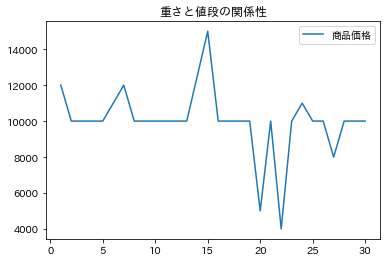

In [ ]:
df.plot(title='重さと値段の関係性')

実用的な解法（ortoolpyに頼る）

In [ ]:
def practical_solution():
  simulator = Simulator()
  weights = [int(data) for i, data in enumerate(df['kg'])]
  prices = [int(data) for i, data in enumerate(df['商品価格'])]
  deduction_limit = simulator.start()
  # ナップサックの場合、ものの値段等が価値で、重さによる制限がある。今回の場合、ものの重さを価値として、値段の制限がある。
  knapsack_problem = KnapsackProblem(values=weights, weights=prices, max_weight=deduction_limit)
  result = knapsack_problem.solve_by_ortoolpy()
  print(f'控除上限額は{deduction_limit}円')
  HTML(df.to_html(render_links=True, escape=False))
  def make_clickable(val):
      return f'<a target="_blank" href="{val}">{val}</a>'
  return df.iloc[result[1]].style.format({'商品URL': make_clickable, '店舗URL': make_clickable})

量子アルゴリズムによる解法（QAOA）

In [ ]:
def futurism_solution():
  simulator = Simulator()
  weights = [int(data) for i, data in enumerate(df['kg'])][0:10] # Colabメモリと量子コンピュータの現在の性能上10件が限界（10件じゃなにもわからないけど許してください）
  prices = [int(data) for i, data in enumerate(df['商品価格'])][0:10] # 以上同様
  deduction_limit = simulator.start()
  # ナップサックの場合、ものの値段等が価値で、重さによる制限がある。今回の場合、ものの重さを価値として、値段の制限がある。
  knapsack_problem = KnapsackProblem(values=weights, weights=prices, max_weight=deduction_limit)
  result = knapsack_problem.solve_by_qaoa()
  print(f'控除上限額は{deduction_limit}円')
  HTML(df.to_html(render_links=True, escape=False))
  def make_clickable(val):
      return f'<a target="_blank" href="{val}">{val}</a>'
  return df.iloc[result].style.format({'商品URL': make_clickable, '店舗URL': make_clickable})

**実行**

結果：実用的な方（控除上限額以内で重いものを選択してくれています）

In [ ]:
practical_solution()

★ふるさと納税寄附上限診断★

※入力する値において、ない場合は0を入力

給与
あなたの給与収入(円)5000000
配偶者の給与収入(夫または妻)(円)0
株式譲渡益(上場)(円)0
株式譲渡益(非上場)(円)0

家族構成
配偶者の有無
1. なし
2. あり(69歳以下)
3. あり(70歳以上))
番号を選んでください。1
寡婦に該当しますか？
1. 非該当
2. 寡婦
3. ひとり親(女性)
4. ひとり親(男性)
番号を選んでください。1
障害者の有無 1. あり, 2. なし2
扶養家族の有無 1. あり, 2. なし2

保険、控除等
社会保険料等の金額(円)0
小規模企業共済等掛金の金額(円)0
生命保険料の控除額(円)0
地震保険料の控除額(円)0
医療費控除の金額(円)0
住宅借入等特別控除額(円)0

寄附金額0

(110.0, [1, 3, 6, 14, 18, 19, 20])
控除上限額は64444円


,商品名,kg,商品価格,商品説明文,商品URL,店舗名,店舗URL
2,【ふるさと納税】期間限定 増量中！14kg→15kg 生産者応援 無洗米 米 コメ 高レビュー 楽天 ランキング 1位 獲得 ジャンル 訳あり 家庭用 熊本ふるさと 無洗 米 今なら 15kg 熊本県産《30日以内に順次出荷(土日祝除く)》 洗わず コロナ おうちご飯 数量限定 期間限定,14,10000,名称 米 使用割合 複数原料米 国内産 10割 熊本県産 （御船町産含む） ヒノヒカリ 3年産 7割 熊本県産 （産地未検査） 3割 内容量 15kg 【選べる精米方法】 1.無洗米のみ (5kg+5kg+5kg) 2.白米のみ (5kg+5kg+5kg) 3.無洗米と白米セット (無洗米5kg 白米5kg+5kg) 精米年月日 米袋に記載 賞味期限 お早めにお召し上がりください。 保存方法 冷暗所や冷蔵庫などで保存してください。 ※米トレーサビリティ法に基づき伝達された産地をその事実に基づいて表示する場合には、「産地未検査」と表示しています。 ・ふるさと納税よくある質問はこちら ・寄附申込みのキャンセル、返礼品の変更・返品はできません。あらかじめご了承ください。 ふるさと納税 米 ふるさと納税 無洗 米 訳あり 家庭用 訳あり お米 精米 簡易包装 国産 10000円 お取り寄せ グルメ 送料無料 10kg以上 賞味期限が短い 心配無 15kg今回掲載させていただいている返礼品は、飲食店やホテルなど、多くのお店への販売・提供品です。今回の新型コロナウィルス感染拡大により、飲食店の営業が自粛対象となり、深刻な影響を受けております。熊本の美味しい水と肥沃な大地が育んだ美味しいお米をお届けいたします。よろしくお願い致します。 寄附金の用途について 「ふるさと納税」寄附金は、下記の事業を推進する資金として活用してまいります。 寄附を希望される皆さまの想いでお選びください。 [1]町長が必要と認める事業 [2]子育て支援、教育に関する事業 [3]安全で快適な環境づくりに関する事業 [4]地域振興に関する事業 ふるさと納税 米 ふるさと納税 無洗 米 訳あり 家庭用 訳あり お米 精米 簡易包装 国産 10000円 お取り寄せ グルメ 送料無料 10kg以上 賞味期限が短い 心配無 15kg,https://item.rakuten.co.jp/f434418-mifune/10000461/,熊本県御船町,https://www.rakuten.co.jp/f434418-mifune/
7,【ふるさと納税】12月 訳あり 蜜入り EM葉取らずサンふじ約10kg 糖度13度以上 【弘前市産・青森りんご・12月】 【果物類・林檎・りんご・リンゴ・サンふじ】 お届け：2021年12月1日〜2021年12月31日,10,12000,名称りんご内容量訳あり糖度13度以上 蜜入り EM葉取らずサンふじ約10kg・26〜46玉程度※色むら、変形、すれ、サビ、つる割れ、小キズ等含む※玉数の指定はできません。※蜜入りは光センサーで検査しますが、蜜は時間の経過とともに果肉に吸収される場合もございますのでご了承ください。（個体差があります。）※到着後、冷暗所か冷蔵庫で保存してください。産地青森県弘前市産事業者有限会社イーエム総合ネット弘前配送方法常温配送お届け時期2021年12月1日〜2021年12月31日備考※画像はイメージです。※季節品のため配送日時指定やお届け日についてのお問合せは承っておりません。注文順に順次出荷いたします。※天候や収穫状況により、お届けや規格が変更になる場合がございます。※配送時の揺れや傾きにより若干の傷が生じる場合がございます。※シーズンに入りましたらご案内メールをいたしますので必ずご確認ください。※商品受取後、すぐに商品の状態をご確認ください。不良の場合現品と交換させて頂きます。お問合せセンターまでご連絡ください。お時間が過ぎてからの交換は致しかねます。※ご不在等により商品を受け取れなかった場合の再出荷は致しかねます。 ・ふるさと納税よくある質問はこちら ・寄附申込みのキャンセル、返礼品の変更・返品はできません。あらかじめご了承ください。【ふるさと納税】12月 訳あり 蜜入り EM葉取らずサンふじ約10kg 糖度13度以上 【弘前市産・青森りんご・12月】 【果物類・林檎・りんご・リンゴ・サンふじ】 お届け：2021年12月1日〜2021年12月31日 【出荷予定：12/1〜12/31 イーエム総合ネット弘前 弘前市産 糖度13度以上 訳あり 蜜入り EM葉取らずサンふじ約10kg・26〜46玉程度※色むら、変形、すれ、サビ、つる割れ、小キズ等含む】EM（有用微生物群）だからこそできる、安心・安全な土づくりが生み出したブランドりんご「EMりんご」。従来の化学肥料を一切用いることなく栽培されています。EMりんごの特徴は、その実の中にたっぷり詰まった旨みや栄養もさることながら、通常のりんごに比べて変色（りんごを切った際の断面に浮かぶ黄色〜褐色の変化）が起きにくい点にあります。これは、りんごそのものの鮮度や品質が高い状態で保たれていることを示しています。甘みを生み出す光合成を行う葉を収穫のギリギリまで取らず、果実に栄養を詰め込んだ葉取らずのサンふじです。葉が日光を遮るため、色むらになりやすく見た目は良くありませんが、糖度は通常のりんごより糖度が1度程度上がるといわれてます。自然あふれる津軽の大地と太陽の恵みが凝縮されたEMりんごをぜひご賞味ください。※5段階規格の内、2〜4番手規格、光センサーで蜜入り、褐変チェック、糖度13度以を検査してお届けします。（蜜は時間と共に果肉に吸収され消滅する場合がございますのでご了承ください。）※到着後、冷蔵庫で保管してお早めにお召し上がりください。食べきれない場合、新聞紙、ラップで包むと日持ちしやすくなります。（不良の場合、到着後1週間以内にてご連絡をお願いします。） 寄附金の用途について 日本一の「さくら」応援コース 弘前4大まつり応援コース 弘前子ども未来応援コース がんばる弘前応援コース 【特別コース】弘前城天守がお引越し！世紀の石垣大修理〜石垣普請応援コース〜※寄付に対する特典して「城主証」を発行。 れんが倉庫が美術館に生まれ変わります〜現代アートコレクション応援コース〜 日本一の「りんご」応援コース 受領証明書及びワンストップ特例申請書のお届けについて 入金確認後、注文内容確認画面の【注文者情報】に記載の住所にお送りいたします。発送の時期は、入金確認後2〜3週間程度を目途に、お礼の特産品とは別にお送りいたします。,https://item.rakuten.co.jp/f022021-hirosaki/52280344/,青森県弘前市,https://www.rakuten.co.jp/f022021-hirosaki/
12,【ふるさと納税】訳あり 阿蘇だわら 合計16kg (5kg×2袋、6kg×1袋) 期間限定 増量 令和3年 緊急 支援品 コロナ支援 米 お米 おこめ 白米 精米 ブレンド米 米俵 規格外 フードロス SDGs 熊本県 高森町 オリジナル米 国産 送料無料 3-10営業日以内出荷(土日祝除く),16,10000,※返礼品の送付は、熊本県高森町外にお住まいの方に限らせていただきます。 精米したて！スピード発送！ 一粒一粒のお米の香りや甘みを感じることが出来る農家さんの産直のお米です。 商品詳細 商品名 【訳あり】阿蘇だわら16kg 熊本県 高森町 オリジナル米 産地 熊本県産(高森産含む） 内容量 5kg×2袋、6kg×1袋【合計16kg】 名称 精米 品種 複数原料米 産年 令和3年度産 使用割合 複数原料米 10割 精米年月日 別途商品記載 検査 未検査米 おいしく食べられる目安 お米は生鮮食品のため※賞味期限表記ではございません。 春夏は精米後2週間から1ヶ月、秋冬にかけては1～2ヶ月程度です。 保存方法 高温・多湿・直射日光を避け、涼しい場所に保管してください。密閉容器に保存し、15℃以下（冷蔵庫野菜室等）での保存がおすすめです。 提供者 有限会社田代米穀 工夫やこだわり 皆様が安心して食べられる「安全安心なお米」を作るため、商品を毎日試食しております。 関わっている人 お米マイスター在籍店！ お米の博士とも言えるお米マイスターが作るお米です。品質・食味を厳選したお米を作っています。 時期 明治時代から精米業として、安心安全のお米を皆様に届けるため、HASCCP認定工場として最新の機器で精米を行っております。 お礼の品に対する想い 今までの経験や技術を活かし、皆様に納得頂けるお米を作っています。 一人でも多くの皆様にご賞味頂けることを楽しみにしています。 ふるさと納税でやりたい事や生まれた変化 ふるさと納税を通して地域の貢献と、皆様に喜んでもらえるお米をより多くの方に届けられる機会を頂いたと思っております。 ・ふるさと納税よくある質問はこちら・寄付申込みのキャンセル、返礼品の変更・返品はできません。あらかじめご了承ください。「ふるさと納税」寄附金は、下記の事業を推進する資金として活用してまいります。 寄附を希望される皆さまの想いでお選びください。 (1) 高森町の魅力溢れる地域「宝物」を活かしたまちづくり事業 (2) 地場産業を活用した高森町のブランド力の向上及び広報事業 (3) 高森町ならではの元気な人づ

結果：未来志向な方（実行開始から終了まで30分~1時間かかります）（控除上限額以内で重いものを選択してくれています）

In [ ]:
futurism_solution()

★ふるさと納税寄附上限診断★

※入力する値において、ない場合は0を入力

給与
あなたの給与収入(円)3000000
配偶者の給与収入(夫または妻)(円)0
株式譲渡益(上場)(円)0
株式譲渡益(非上場)(円)0

家族構成
配偶者の有無
1. なし
2. あり(69歳以下)
3. あり(70歳以上))
番号を選んでください。1
寡婦に該当しますか？
1. 非該当
2. 寡婦
3. ひとり親(女性)
4. ひとり親(男性)
番号を選んでください。1
障害者の有無 1. あり, 2. なし2
扶養家族の有無 1. あり, 2. なし2

保険、控除等
社会保険料等の金額(円)0
小規模企業共済等掛金の金額(円)0
生命保険料の控除額(円)0
地震保険料の控除額(円)0
医療費控除の金額(円)0
住宅借入等特別控除額(円)0

寄附金額0

[1, 5, 6]
控除上限額は30222円


,商品名,kg,商品価格,商品説明文,商品URL,店舗名,店舗URL
2,【ふるさと納税】期間限定 増量中！14kg→15kg 生産者応援 無洗米 米 コメ 高レビュー 楽天 ランキング 1位 獲得 ジャンル 訳あり 家庭用 熊本ふるさと 無洗 米 今なら 15kg 熊本県産《30日以内に順次出荷(土日祝除く)》 洗わず コロナ おうちご飯 数量限定 期間限定,14,10000,名称 米 使用割合 複数原料米 国内産 10割 熊本県産 （御船町産含む） ヒノヒカリ 3年産 7割 熊本県産 （産地未検査） 3割 内容量 15kg 【選べる精米方法】 1.無洗米のみ (5kg+5kg+5kg) 2.白米のみ (5kg+5kg+5kg) 3.無洗米と白米セット (無洗米5kg 白米5kg+5kg) 精米年月日 米袋に記載 賞味期限 お早めにお召し上がりください。 保存方法 冷暗所や冷蔵庫などで保存してください。 ※米トレーサビリティ法に基づき伝達された産地をその事実に基づいて表示する場合には、「産地未検査」と表示しています。 ・ふるさと納税よくある質問はこちら ・寄附申込みのキャンセル、返礼品の変更・返品はできません。あらかじめご了承ください。 ふるさと納税 米 ふるさと納税 無洗 米 訳あり 家庭用 訳あり お米 精米 簡易包装 国産 10000円 お取り寄せ グルメ 送料無料 10kg以上 賞味期限が短い 心配無 15kg今回掲載させていただいている返礼品は、飲食店やホテルなど、多くのお店への販売・提供品です。今回の新型コロナウィルス感染拡大により、飲食店の営業が自粛対象となり、深刻な影響を受けております。熊本の美味しい水と肥沃な大地が育んだ美味しいお米をお届けいたします。よろしくお願い致します。 寄附金の用途について 「ふるさと納税」寄附金は、下記の事業を推進する資金として活用してまいります。 寄附を希望される皆さまの想いでお選びください。 [1]町長が必要と認める事業 [2]子育て支援、教育に関する事業 [3]安全で快適な環境づくりに関する事業 [4]地域振興に関する事業 ふるさと納税 米 ふるさと納税 無洗 米 訳あり 家庭用 訳あり お米 精米 簡易包装 国産 10000円 お取り寄せ グルメ 送料無料 10kg以上 賞味期限が短い 心配無 15kg,https://item.rakuten.co.jp/f434418-mifune/10000461/,熊本県御船町,https://www.rakuten.co.jp/f434418-mifune/
9,【ふるさと納税】ご家庭用訳ありラ・フランス約6kg_H071(R4),6,10000,返礼品詳細 お口の中いっぱいに広がる豊かな香り、とろけるようなまろやかさが特長のラ・フランスは、くだもの王国山形を代表する逸品です。 【訳あり】であるため、大きさ、形にバラつきがあったり、傷がついているものもありますが、ご家庭用としては十分お楽しみいただけます。 濃厚な甘み、高貴な香りをお楽しみください。 【以下の注意事項について予めご了承いただいた上でお申込みください。】 ※贈答用には適さない規格外品です。そのほか、配送時の揺れや傾きにより若干の傷等が生じる場合がございます。 ※収穫状況によっては、やむを得ず、配送時期を変更する場合や、ご希望の品物をご用意できず代替品をご用意する場合がございます。その際は、ご登録いただいたアドレス宛へのメール等にてご連絡いたします。 ※沖縄県（本島を除く）および離島への発送はできません。 容量 約6kg（約3kg×2箱） 賞味期限 出荷日より14日 申込期日 2022年11月20日頃まで 発送期日 2022年11月1日頃から11月30日頃にかけて、寄付受付順に発送 配送 常温 協力事業者 長井中央青果 よくある質問・その他 ・ふるさと納税に関するよくある質問はこちら ・寄附申込みのキャンセル、返礼品の変更・返品はできません。あらかじめご了承ください。ご家庭用訳ありラ・フランス約6kg_H071(R4) 「ふるさと納税」寄付金は、下記の事業を推進する資金として活用してまいります。 (1) 子育てに関する事業 (2) 教育及び文化の振興に関する事業 (3) 環境の保護・保全に関する事業 (4) その他市長が必要と認める事業 特段のご希望がなければ、市政全般に活用いたします。 入金確認後、注文内容確認画面の【注文者情報】に記載の住所にお送りいたします。 ワンストップ特例申請書は、ご希望の場合のみお送りいたします 発送の時期は、寄附確認後30日以内を目途に、お礼の特産品とは別にお送りいたします。,https://item.rakuten.co.jp/f062090-nagai/1-532/,山形県長井市,https://www.rakuten.co.jp/f062090-nagai/
12,【ふるさと納税】訳あり 阿蘇だわら 合計16kg (5kg×2袋、6kg×1袋) 期間限定 増量 令和3年 緊急 支援品 コロナ支援 米 お米 おこめ 白米 精米 ブレンド米 米俵 規格外 フードロス SDGs 熊本県 高森町 オリジナル米 国産 送料無料 3-10営業日以内出荷(土日祝除く),16,10000,※返礼品の送付は、熊本県高森町外にお住まいの方に限らせていただきます。 精米したて！スピード発送！ 一粒一粒のお米の香りや甘みを感じることが出来る農家さんの産直のお米です。 商品詳細 商品名 【訳あり】阿蘇だわら16kg 熊本県 高森町 オリジナル米 産地 熊本県産(高森産含む） 内容量 5kg×2袋、6kg×1袋【合計16kg】 名称 精米 品種 複数原料米 産年 令和3年度産 使用割合 複数原料米 10割 精米年月日 別途商品記載 検査 未検査米 おいしく食べられる目安 お米は生鮮食品のため※賞味期限表記ではございません。 春夏は精米後2週間から1ヶ月、秋冬にかけては1～2ヶ月程度です。 保存方法 高温・多湿・直射日光を避け、涼しい場所に保管してください。密閉容器に保存し、15℃以下（冷蔵庫野菜室等）での保存がおすすめです。 提供者 有限会社田代米穀 工夫やこだわり 皆様が安心して食べられる「安全安心なお米」を作るため、商品を毎日試食しております。 関わっている人 お米マイスター在籍店！ お米の博士とも言えるお米マイスターが作るお米です。品質・食味を厳選したお米を作っています。 時期 明治時代から精米業として、安心安全のお米を皆様に届けるため、HASCCP認定工場として最新の機器で精米を行っております。 お礼の品に対する想い 今までの経験や技術を活かし、皆様に納得頂けるお米を作っています。 一人でも多くの皆様にご賞味頂けることを楽しみにしています。 ふるさと納税でやりたい事や生まれた変化 ふるさと納税を通して地域の貢献と、皆様に喜んでもらえるお米をより多くの方に届けられる機会を頂いたと思っております。 ・ふるさと納税よくある質問はこちら・寄付申込みのキャンセル、返礼品の変更・返品はできません。あらかじめご了承ください。「ふるさと納税」寄附金は、下記の事業を推進する資金として活用してまいります。 寄附を希望される皆さまの想いでお選びください。 (1) 高森町の魅力溢れる地域「宝物」を活かしたまちづくり事業 (2) 地場産業を活用した高森町のブランド力の向上及び広報事業 (3) 高森町ならではの元気な人づくり事業 (4) エンタメ業界と連携したまちづくり事業 (5) 熊本地震で被災した地域を支えるローカル線｢南阿蘇鉄道｣の全線復旧支援事業 (6) その他、より良いふるさとのまちづくりに必要な事業 ■受領証明書及びワンストップ特例申請書（希望する選択の場合）はご注文者様情報のご住所宛へ 返礼品とは別に約「2週間～4週間」程度でお送りいたします。 ※【1月】お申し込み分につきましては、昨年お申し込み分との混同を避ける為、「2月」より順次発送いたします。 （注）返礼品とは別にお送りします、受領証明書及びワンストップ特例申請書より先に返礼品が届く場合がございます。 ■ワンストップ特例申請書の送付先 〒869-1602 熊本県高森町大字高森2168番地 高森町役場 政策推進課まちづくり係 宛て ※記入方法など、詳しくはこちらをご覧ください。 https://event.rakuten.co.jp/furusato/guide/onestop.html,https://item.rakuten.co.jp/f434281-takamori/078-566/,熊本県高森町,https://www.rakuten.co.jp/f434281-takamori/


### 参考

上限控除シミュレーション<br/>
https://furusatoplus.com/info/003/<br/>
上限控除シミュレーション<br/>
https://www.furusato-tax.jp/about/easy_simulation<br/>
控除上限額<br/>
https://www.youtube.com/watch?v=2N3BJ6fROVc&t=667s<br/>
控除上限額早見表<br/>
https://furusato.wowma.jp/guide/simulator_upper_limit.php<br/>
給与所得控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1410.htm<br/>
配偶者控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1191.htm<br/>
配偶者特別控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1195.htm<br/>
寡婦控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1172.htm<br/>
障害者控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1160.htm<br/>
扶養控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1180.htm<br/>
基礎控除<br/>
https://www.nta.go.jp/taxes/shiraberu/taxanswer/shotoku/1199.htm<br/>
組合せ最適化<br/>
https://qiita.com/SaitoTsutomu/items/bfbf4c185ed7004b5721<br/>
楽天商品検索API<br/>
https://qiita.com/massa-potato/items/831ace8b4527d90653a8<br/>
量子最適化（量子ゲート）<br/>
https://arxiv.org/pdf/1411.4028.pdf<br/>
https://qiskit.org/documentation/optimization/locale/ja_JP/tutorials/09_application_classes.html<br/>
量子最適化の応用<br/>
https://arxiv.org/pdf/2108.08805.pdf<br/>
ナップサック問題<br/>
https://ja.wikipedia.org/wiki/%E3%83%8A%E3%83%83%E3%83%97%E3%82%B5%E3%83%83%E3%82%AF%E5%95%8F%E9%A1%8C<br/>
QAOAナップサック<br/>
https://arxiv.org/pdf/1908.02210.pdf<br/>
イジングモデルナップサック（量子アニーリング）<br/>
https://blueqat.com/yuichiro_minato2/c6ba30e7-1f7b-4681-bd60-da36b1f683fd<br/>
ハミルトニアン<br/>
https://github.com/hodaka0714/saize_calory_maxmization/blob/master/saize_calory_maxmization.ipynb
